# Decision tree

## Imports

In [16]:
# Imports
import sys

# Adds the project root and utils directory to the PYTHONPATH
sys.path.append("..")
sys.path.append("../utils")  

# Imports everything from common_imports.py and config
from common_imports import *  
from config import *

# Load train / test datasets
# Train sets
X_train = pd.read_csv(X_train_path)
y_train = pd.read_csv(y_train_path)

# Test sets
X_test = pd.read_csv(X_test_path)
y_test = pd.read_csv(y_test_path)

## Modelling

In [17]:
# Instantiate a decision tree model
tree = DecisionTreeClassifier(random_state=42)

# Dictionnary of hyperparameters
cv_params = {'max_depth' : [4, 6, 8, None],
             'min_samples_leaf' : [1, 2, 5],
             'min_samples_split' : [2, 4, 6]}

# Scoring
scoring = {'f1' : 'f1', 
           'accuracy' : 'accuracy', 
           'precision' : 'precision', 
           'recall' : 'recall', 
           'roc_auc' : 'roc_auc'}

# Instantiate GridSearch
tree_cv1 = GridSearchCV(tree, cv_params, scoring=scoring, cv=5, refit='roc_auc', verbose=True, n_jobs=-1) 


Fit the decision tree model to the training data.

In [18]:
%%time
tree_cv1.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
CPU times: user 187 ms, sys: 162 ms, total: 349 ms
Wall time: 2.21 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'},
             verbose=True)

In [19]:
# Define saving path
path = '../model/'

# Write pickle
write_pickle(path, tree_cv1, 'hr_dt1')

In [20]:
# Best parameters
tree_cv1.best_params_

{'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2}

In [21]:
# Best score
tree_cv1.best_score_

0.9737456046840824

This is a strong AUC score, which shows that this model can predict employees who will leave very well.

Use utility function to get all the scores from grid search.

In [22]:
# Load `model_results` DataFrame
results = pd.read_csv(model_results_path)

# Get all CV scores
tree1_cv_results = make_results('decision tree cv', tree_cv1, 'auc')

# Show model results
tree1_cv_results

,model,precision,recall,F1,accuracy,AUC
0,decision tree cv,0.957783,0.91423,0.935393,0.978746,0.973746


In [23]:
# Update `results` DataFrame
results = pd.concat([results, tree1_cv_results], axis=0)

# Sort 'results' by F1-score
results = results.sort_values(by='F1', ascending=False).reset_index(drop=True)

# Compare results to other saved results
results

,model,precision,recall,F1,accuracy,AUC
0,decision tree cv,0.957783,0.914230,0.935393,0.978746,0.973746
1,logistic regression,0.789932,0.819126,0.799433,0.819126,0.595905


All of these scores from the decision tree model are strong indicators of good model performance.

In [24]:
# Get predictions from test data
tree_test_scores = get_scores('decision tree test', tree_cv1, X_test, y_test)

# Update `results` DataFrame
results = pd.concat([results, tree_test_scores], axis=0)

# Sort 'results' by F1-score
results = results.sort_values(by='F1', ascending=False).reset_index(drop=True)

# Save `results` DataFrame
results.to_csv('../model/model_results.csv', index=False)

# Display `results` Dataframe
results

,model,precision,recall,F1,accuracy,AUC
0,decision tree test,0.962637,0.929936,0.946004,0.982092,0.961306
1,decision tree cv,0.957783,0.914230,0.935393,0.978746,0.973746
2,logistic regression,0.789932,0.819126,0.799433,0.819126,0.595905


## Tree Visualisation

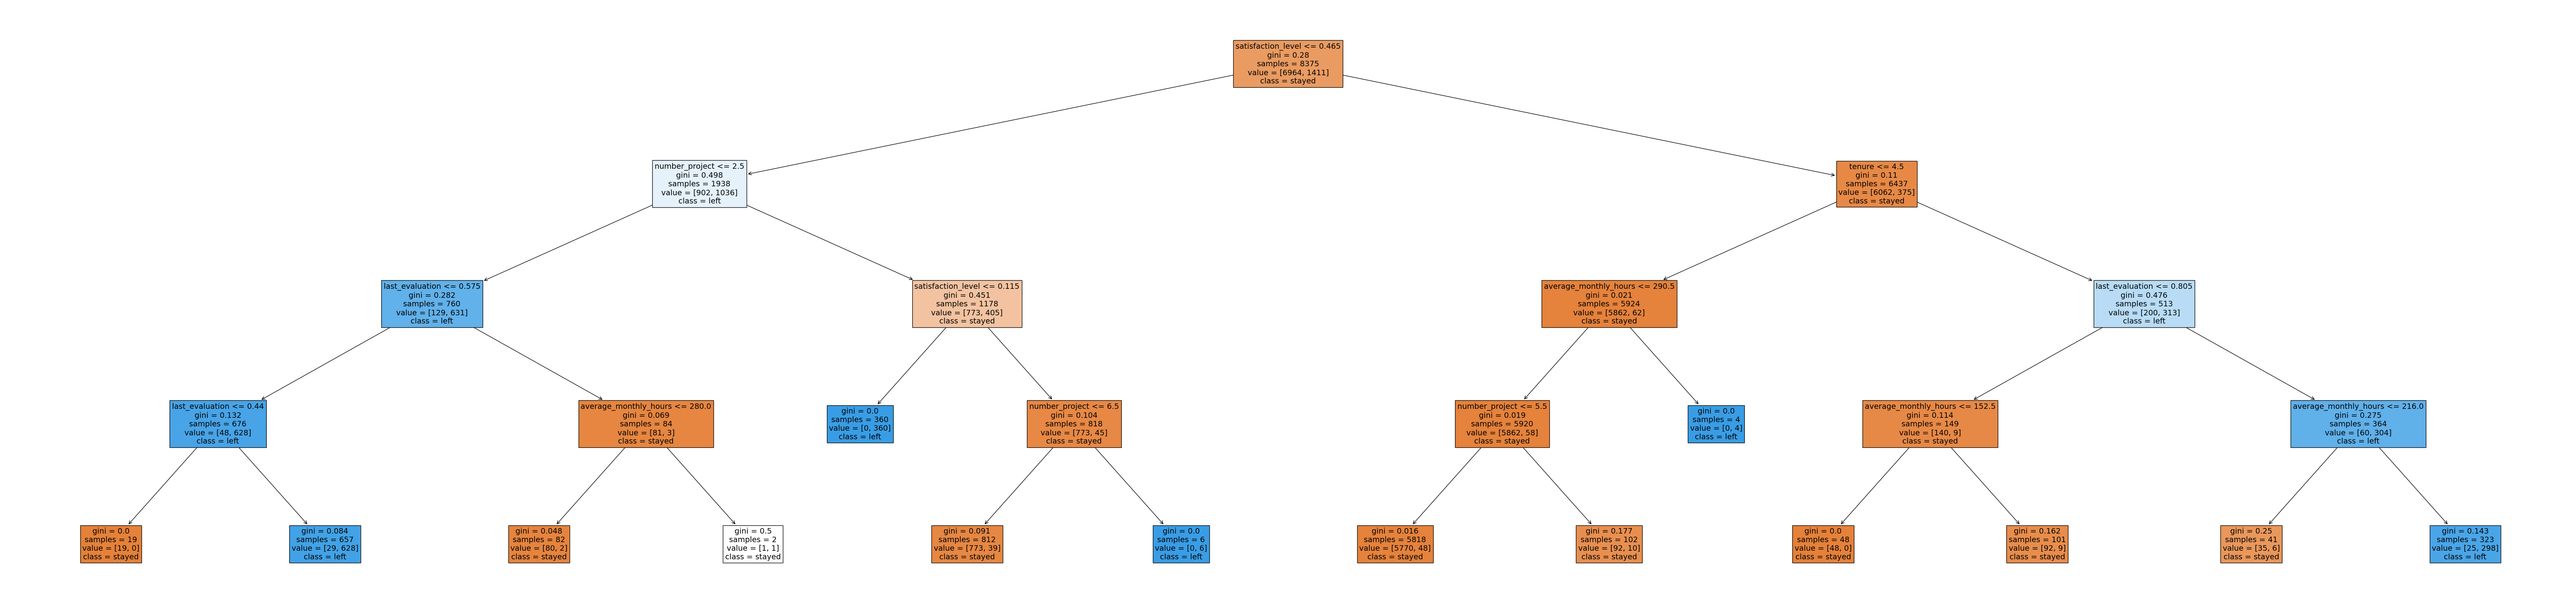

In [25]:
# Load X and y
X = pd.read_csv(X_path)
y = pd.read_csv(y_path)

# Extract column names
feature_names = list(X.columns)

# Class names
class_names = ['stayed', 'left']

# Plot the tree
plt.figure(figsize=(85,20))
plot_tree(tree_cv1.best_estimator_, 
          max_depth=6, fontsize=14, 
          feature_names=feature_names, 
          class_names=class_names, 
          filled=True);
plt.show()

## Feature Importance

In [26]:
tree_importances = pd.DataFrame(tree_cv1.best_estimator_.feature_importances_, 
                                 columns=['gini_importance'], 
                                 index=X.columns
                                )
tree_importances = tree_importances.sort_values(by='gini_importance', ascending=False)

# Only extract the features with importances > 0
tree_importances = tree_importances[tree_importances['gini_importance'] != 0]
tree_importances

,gini_importance
satisfaction_level,0.553990
tenure,0.167601
last_evaluation,0.138160
number_project,0.114046
average_monthly_hours,0.026202


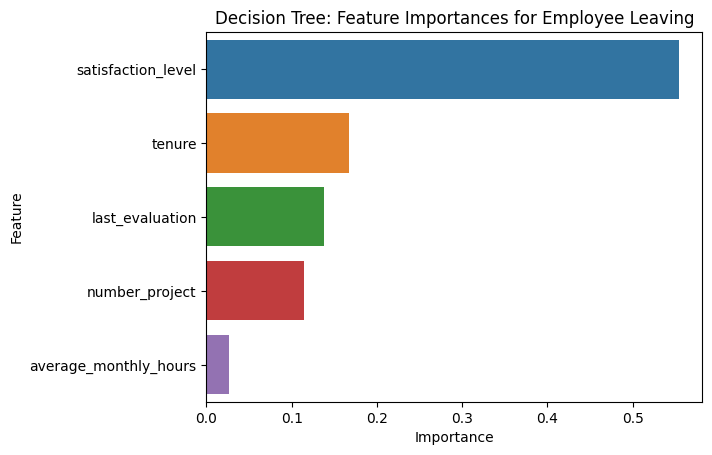

In [27]:
sns.barplot(data=tree_importances, x="gini_importance", y=tree_importances.index, orient='h')
plt.title("Decision Tree: Feature Importances for Employee Leaving", fontsize=12)
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.show()

The features with the highest contribution in order of importance are : `satisfaction_level`, `tenure`, `last_evaluation`, `number_project` and `average_monthly_hours`.